# Annotate abundance changes with ClinVar labels

In [44]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 0. Load data

In [45]:
dualipa_outputs = "../3_outputs"
metadata_outputs = "../../../1_allele_collection/1_inputs"
integrative_inputs = "../../../3_integrated_assay_analyses/1_inputs/dual_ipa"
# priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus"]

In [46]:
# # process metadata
## To be deleted
# metadata = pl.DataFrame(pd.read_csv(f"{metadata_outputs}/varchamp_consolidated_alleles_clinvar_gnomad_dbnsfp_scores.tsv", sep="\t", low_memory=False))
# mut_cols = ["mutation_id_rc4", "mutation_id_cegs2", "mutation_id_edgotyping3"]
# id_vars = [col for col in metadata.columns if col not in mut_cols]
# metadata = metadata.unpivot(index=id_vars, 
#                             on=mut_cols,
#                             variable_name="mutation_collection",
#                             value_name="mut_id")

# metadata = metadata.select(priority_col).filter(~pl.col("mut_id").is_null()).with_columns(
#     pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
#     pl.col("orf_id").cast(pl.Int64).alias("orf_id")
# )

# merge scores with metadata
scores = pl.read_csv(f"{dualipa_outputs}/DUALIPA_median_zscore.csv", separator=",", infer_schema_length=1000000)
# scores = scores.join(metadata, on=["orf_id", "mut_id"], suffix='_meta')
# scores = scores.select(pl.col(priority_col))
scores = scores.filter(~pl.col("zscore_log2").is_null())

## 1. Abudance log2(z-score) dist. in each ClinVar category

### 1.1 All ClinVar variants with somewhat clear annotations (other than "Others")

ClinVar Variants Number: 741


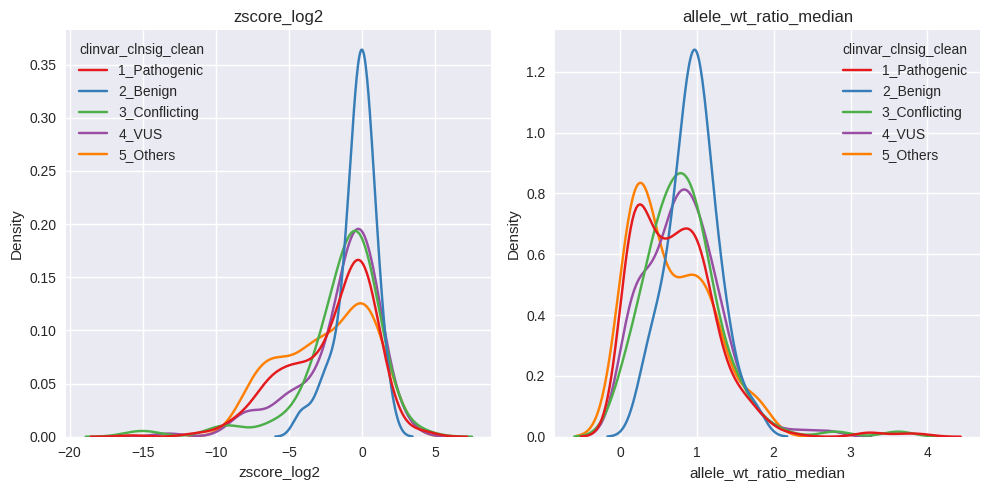

In [47]:
# Define variables to plot
variables = ["zscore_log2", "allele_wt_ratio_median"]
num_vars = len(variables)
print("ClinVar Variants Number:", scores.shape[0])

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5))
hue_order = sorted(scores["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

### 1.2 All ClinVar variants with somewhat clear annotations (other than "Others") & _ReviewStarStatus>=1_

ClinVar Variants (StarStatus >= 1) Number: 532


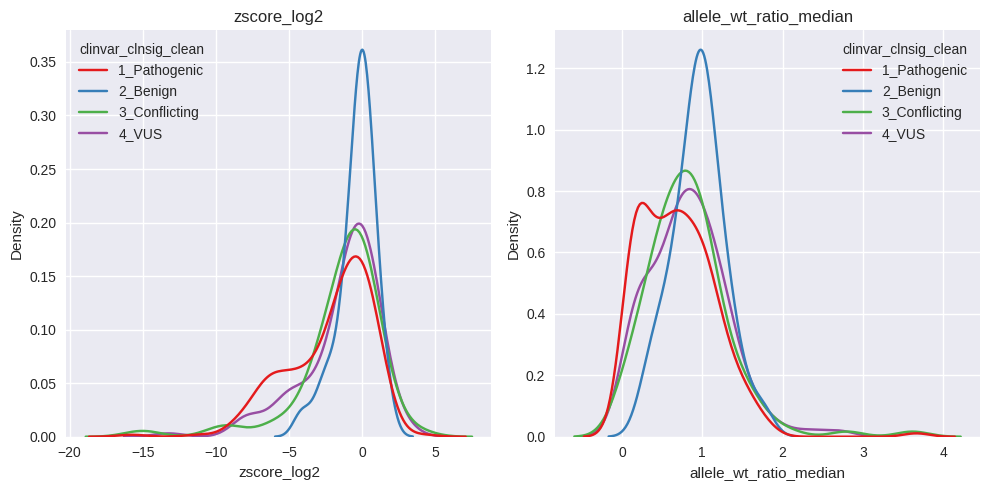

In [48]:
# Define variables to plot
variables = ["zscore_log2", "allele_wt_ratio_median"]
num_vars = len(variables)

scores_filt = scores.filter(pl.col("StarStatus") >= 1)
print("ClinVar Variants (StarStatus >= 1) Number:", scores_filt.shape[0])

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5))
hue_order = sorted(scores_filt["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores_filt,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

# of Benign variants: 63
# of Pathogenic variants: 339
# of VUS variants: 130
# of Conflicting variants: 119


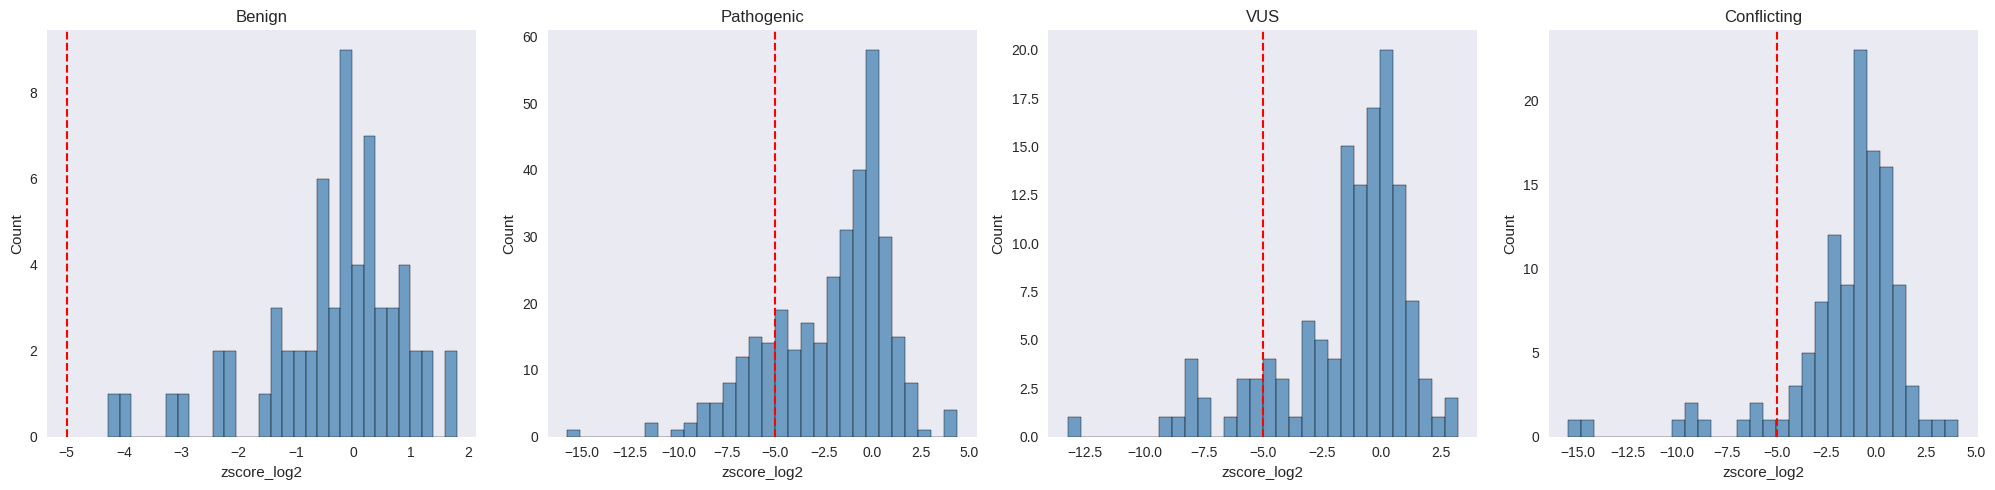

With this threshold, we classify 12.308% VUS,
AND 8.403% conflicting alleles as pathogenic.
This threshold classifies 0.000% of benign variants as pathogenic


In [49]:
plot_var = "zscore_log2"
thresh = -5

benign_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign")
print("# of Benign variants:", benign_scores.shape[0])

path_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "1_Pathogenic")
print("# of Pathogenic variants:", path_scores.shape[0])

vus_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "4_VUS")
print("# of VUS variants:", vus_scores.shape[0])

conf_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "3_Conflicting")
print("# of Conflicting variants:", conf_scores.shape[0])

# Setup subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_data = [
    ("Benign", benign_scores, axs[0]),
    ("Pathogenic", path_scores, axs[1]),
    ("VUS", vus_scores, axs[2]),
    ("Conflicting", conf_scores, axs[3]),
]

# Plot each group
for title, data, ax in plot_data:
    sns.histplot(data=data, x=plot_var, bins=30, color="steelblue", kde=False, ax=ax)
    ax.axvline(thresh, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel(plot_var)
    ax.set_ylabel("Count")
    ax.grid(False)

plt.tight_layout()
plt.show()

benign_misclass = benign_scores.filter(pl.col(plot_var) < thresh).shape[0]
benign_total = benign_scores.shape[0]
print(f"With this threshold, we classify {vus_scores.filter(pl.col(plot_var) < thresh).shape[0]/vus_scores.shape[0]*100:.3f}% VUS,")
print(f"AND {conf_scores.filter(pl.col(plot_var) < thresh).shape[0]/conf_scores.shape[0]*100:.3f}% conflicting alleles as pathogenic.")
print(f"This threshold classifies {benign_misclass/benign_total*100:.3f}% of benign variants as pathogenic")
# This is ~13.4% of VUS/conflicting

In [50]:
path_scores.filter(pl.col(plot_var) < -5).shape[0] / path_scores.shape[0]

0.19174041297935104

## 2. Find the optimal threshold for calling hits

In [51]:
class DistributionAnalyzer:
    """
    Class to analyze and compare distributions using Gaussian Mixture Models
    """
    
    def __init__(self, data_dict):
        """
        Initialize with data dictionary where keys are category names and values are arrays
        """
        self.data_dict = data_dict
        self.fitted_models = {}
        self.model_info = {}
        
    def fit_gmm(self, category, n_components_range=(1, 5), criterion='bic'):
        """
        Fit Gaussian Mixture Model with optimal number of components
        """
        data = self.data_dict[category].reshape(-1, 1)
        
        # Test different numbers of components
        scores = []
        models = []
        
        for n_comp in range(n_components_range[0], n_components_range[1] + 1):
            gmm = GaussianMixture(n_components=n_comp, random_state=42)
            gmm.fit(data)
            
            if criterion == 'bic':
                score = gmm.bic(data)
            else:  # aic
                score = gmm.aic(data)
                
            scores.append(score)
            models.append(gmm)
        
        # Select best model (lowest BIC/AIC)
        best_idx = np.argmin(scores)
        best_model = models[best_idx]
        best_n_comp = best_idx + n_components_range[0]
        
        self.fitted_models[category] = best_model
        self.model_info[category] = {
            'n_components': best_n_comp,
            'score': scores[best_idx],
            'means': best_model.means_.flatten(),
            'covariances': best_model.covariances_.flatten(),
            'weights': best_model.weights_
        }
        return best_model
    
    def fit_all_categories(self):
        """
        Fit GMM for all categories
        """
        for category in self.data_dict.keys():
            self.fit_gmm(category)
    
    def plot_distributions_with_gmm(self, figsize=(15, 10)):
        """
        Plot original distributions with fitted GMM overlays
        """
        n_categories = len(self.data_dict)
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        colors = ['red', 'blue', 'green', 'purple']
        for i, (category, data) in enumerate(self.data_dict.items()):
            ax = axes[i]
            
            # Plot histogram
            ax.hist(data, bins=50, density=True, alpha=0.6, 
                    color=colors[i], label=f'{category} (Data)')
            
            # Plot fitted GMM
            if category in self.fitted_models:
                x_range = np.linspace(data.min(), data.max(), 1000)
                gmm = self.fitted_models[category]
                
                # Overall GMM
                log_prob = gmm.score_samples(x_range.reshape(-1, 1))
                prob = np.exp(log_prob)
                ax.plot(x_range, prob, color='black', linewidth=2, 
                       label=f'GMM ({self.model_info[category]["n_components"]} components)')
                
                # Individual components
                for j in range(gmm.n_components):
                    component_prob = gmm.weights_[j] * stats.norm.pdf(
                        x_range, 
                        gmm.means_[j, 0], 
                        np.sqrt(gmm.covariances_[j, 0, 0])
                    )
                    ax.plot(x_range, component_prob, '--', alpha=0.7,
                           label=f'Component {j+1}')
            
            ax.set_title(f'{category}')
            ax.set_xlabel('zscore_log2')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compare_with_null(self, null_category='2_Benign'):
        """
        Compare all distributions with the null distribution (2_Benign)
        """
        if null_category not in self.fitted_models:
            raise ValueError(f"Null category {null_category} not found in fitted models")
        
        null_model = self.fitted_models[null_category]
        results = {}
        
        for category, model in self.fitted_models.items():
            if category == null_category:
                continue
                
            # Calculate KL divergence
            kl_div = self._calculate_kl_divergence(null_model, model)
            
            # Identify extra peaks
            extra_peaks = self._identify_extra_peaks(null_model, model, category)
            
            results[category] = {
                'kl_divergence': kl_div,
                'extra_peaks': extra_peaks,
                'n_components': self.model_info[category]['n_components'],
                'null_n_components': self.model_info[null_category]['n_components']
            }
        
        return results
    
    def _calculate_kl_divergence(self, model1, model2, n_samples=10000):
        """
        Calculate KL divergence between two GMM models
        """
        # Sample points for comparison
        data_range = np.linspace(-25, 5, n_samples).reshape(-1, 1)
        
        # Get log probabilities
        log_prob1 = model1.score_samples(data_range)
        log_prob2 = model2.score_samples(data_range)
        
        # Convert to probabilities and normalize
        prob1 = np.exp(log_prob1)
        prob2 = np.exp(log_prob2)
        
        prob1 = prob1 / np.sum(prob1)
        prob2 = prob2 / np.sum(prob2)
        
        # Calculate KL divergence (avoid log(0))
        epsilon = 1e-10
        kl_div = np.sum(prob2 * np.log((prob2 + epsilon) / (prob1 + epsilon)))
        
        return kl_div
    
    def _identify_extra_peaks(self, null_model, target_model, category):
        """
        Identify extra peaks in target distribution compared to null
        """
        null_means = null_model.means_.flatten()
        target_means = target_model.means_.flatten()
        target_weights = target_model.weights_
        
        # Find target peaks that are far from null peaks
        extra_peaks = []
        threshold_distance = 2.0  # Adjust based on your data scale
        
        for i, (mean, weight) in enumerate(zip(target_means, target_weights)):
            # Check if this peak is far from all null peaks
            min_distance = np.min(np.abs(mean - null_means))
            
            if min_distance > threshold_distance and weight > 0.1:  # Significant weight
                extra_peaks.append({
                    'mean': mean,
                    'weight': weight,
                    'component': i,
                    'distance_from_null': min_distance
                })
        
        return extra_peaks
    
    def find_optimal_threshold(self, null_category='2_Benign', target_category='1_Pathogenic'):
        """
        Find optimal threshold to separate null from target distribution
        """
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category]
        
        # Define range for threshold search
        min_val = min(null_data.min(), target_data.min())
        max_val = max(null_data.max(), target_data.max())
        
        def objective(threshold):
            # Calculate misclassification rate
            null_misclass = np.sum(null_data < threshold) / len(null_data)
            target_misclass = np.sum(target_data >= threshold) / len(target_data)
            return null_misclass + target_misclass
        
        # Find optimal threshold
        result = minimize_scalar(objective, bounds=(min_val, max_val), method='bounded')
        optimal_threshold = result.x
        
        # Calculate performance metrics
        null_correct = np.sum(null_data >= optimal_threshold) / len(null_data)
        target_correct = np.sum(target_data < optimal_threshold) / len(target_data)
        
        return {
            'threshold': optimal_threshold,
            'null_accuracy': null_correct,
            'target_accuracy': target_correct,
            'overall_accuracy': (null_correct + target_correct) / 2
        }
    
    def plot_comparison_with_threshold(self, null_category='2_Benign', 
                                     target_category='1_Pathogenic', figsize=(12, 8)):
        """
        Plot comparison between null and target with optimal threshold
        """
        threshold_info = self.find_optimal_threshold(null_category, target_category)
        threshold = threshold_info['threshold']
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
        
        # Plot 1: Overlapping distributions with threshold
        null_data = self.data_dict[null_category]
        target_data = self.data_dict[target_category]
        
        ax1.hist(null_data, bins=50, density=True, alpha=0.6, 
                color='blue', label=f'{null_category} (NULL)')
        ax1.hist(target_data, bins=50, density=True, alpha=0.6, 
                color='red', label=f'{target_category}')
        
        # Add fitted GMM curves
        x_range = np.linspace(min(null_data.min(), target_data.min()), 
                             max(null_data.max(), target_data.max()), 1000)
        
        null_prob = np.exp(self.fitted_models[null_category].score_samples(x_range.reshape(-1, 1)))
        target_prob = np.exp(self.fitted_models[target_category].score_samples(x_range.reshape(-1, 1)))
        
        ax1.plot(x_range, null_prob, color='blue', linewidth=2, linestyle='--')
        ax1.plot(x_range, target_prob, color='red', linewidth=2, linestyle='--')
        
        # Add threshold line
        ax1.axvline(threshold, color='black', linestyle='-', linewidth=2, 
                   label=f'Optimal Threshold: {threshold:.2f}')
        
        ax1.set_xlabel('zscore_log2')
        ax1.set_ylabel('Density')
        ax1.set_title(f'Distribution Comparison: {null_category} vs {target_category}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Difference in distributions
        diff = target_prob - null_prob
        ax2.plot(x_range, diff, color='purple', linewidth=2)
        ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax2.axvline(threshold, color='black', linestyle='-', linewidth=2, alpha=0.7)
        ax2.fill_between(x_range, diff, 0, where=(diff > 0), alpha=0.3, color='red')
        ax2.fill_between(x_range, diff, 0, where=(diff < 0), alpha=0.3, color='blue')
        
        ax2.set_xlabel('zscore_log2')
        ax2.set_ylabel('Density Difference')
        ax2.set_title(f'Difference: {target_category} - {null_category}')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"Threshold Analysis Results:")
        print(f"Optimal Threshold: {threshold:.3f}")
        print(f"{null_category} Accuracy: {threshold_info['null_accuracy']:.3f}")
        print(f"{target_category} Accuracy: {threshold_info['target_accuracy']:.3f}")
        print(f"Overall Accuracy: {threshold_info['overall_accuracy']:.3f}")
    
    def generate_summary_report(self):
        ## Generate a comprehensive summary report
        print("=== GAUSSIAN MIXTURE MODEL ANALYSIS REPORT ===")
        print("\\n1. MODEL FITTING RESULTS:")
        
        for category, info in self.model_info.items():
            print(f"\\n{category}:\"")
            print(f"  - Optimal components: {info['n_components']}")
            print(f"  - BIC score: {info['score']:.2f}")
            print(f"  - Component means: {info['means']}")
            print(f"  - Component weights: {info['weights']}")
        
        print("\n2. COMPARISON WITH NULL (2_Benign):")
        comparison_results = self.compare_with_null()
        
        for category, results in comparison_results.items():
            print(f"\\n{category}:")
            print(f"  - KL Divergence from null: {results['kl_divergence']:.4f}")
            print(f"  - Number of extra peaks: {len(results['extra_peaks'])}")
            
            if results['extra_peaks']:
                for i, peak in enumerate(results['extra_peaks']):
                    print(f"    Peak {i+1}: mean={peak['mean']:.2f}, weight={peak['weight']:.3f}")

Fitting Gaussian Mixture Models...
Plotting distributions with GMM overlays...


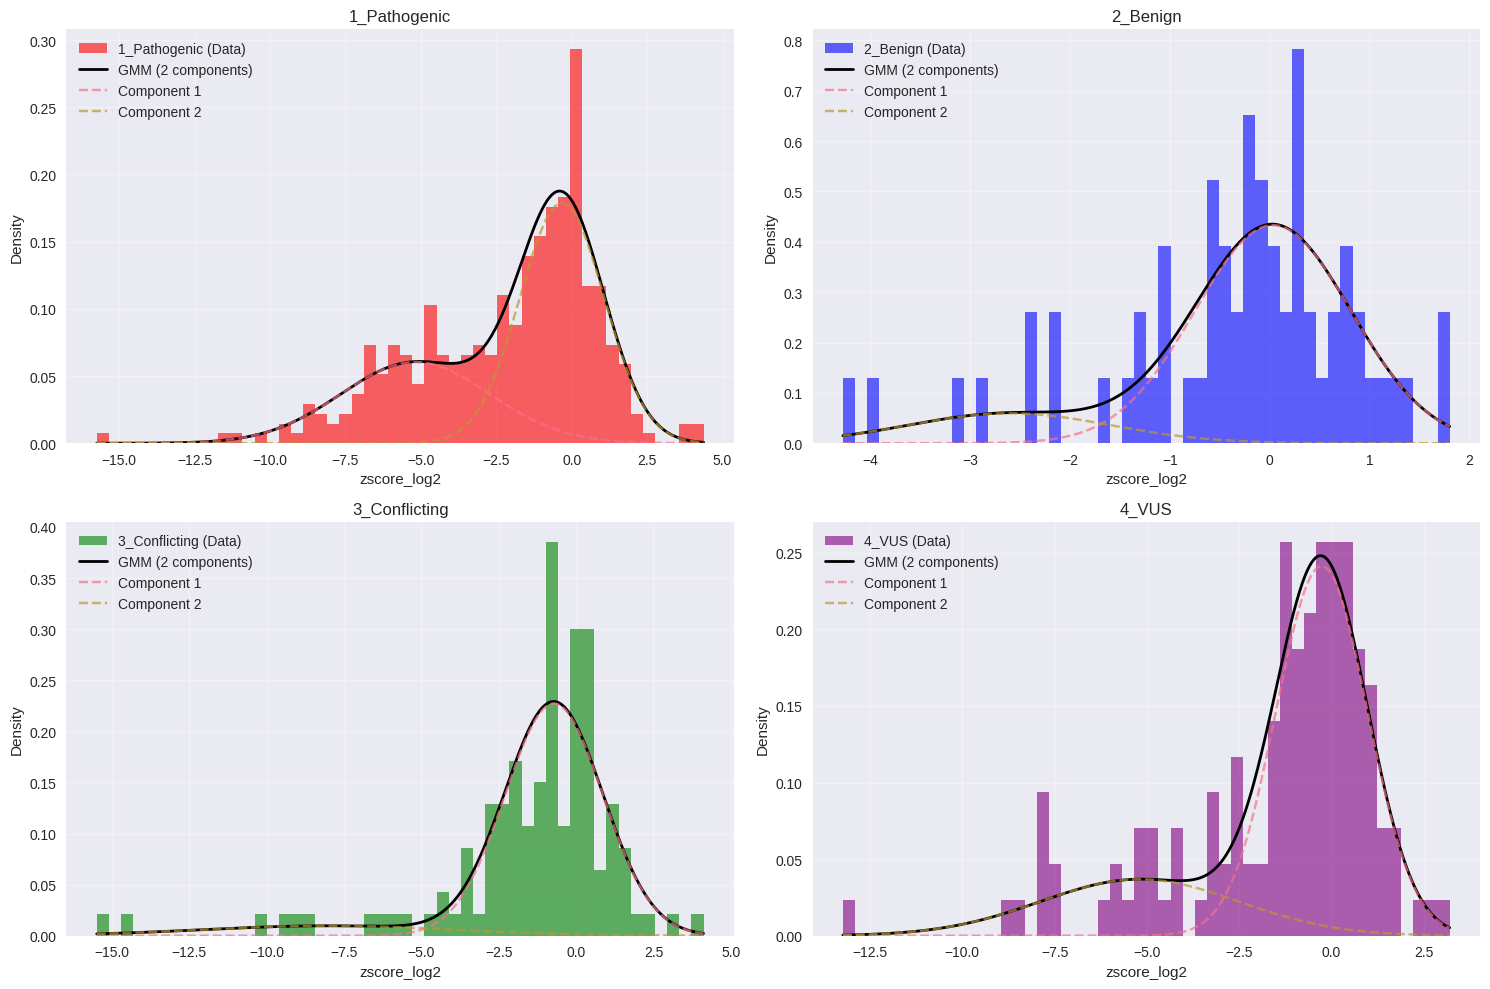

=== GAUSSIAN MIXTURE MODEL ANALYSIS REPORT ===
\n1. MODEL FITTING RESULTS:
\n1_Pathogenic:"
  - Optimal components: 2
  - BIC score: 1665.06
  - Component means: [-5.18484685 -0.32069845]
  - Component weights: [0.37349619 0.62650381]
\n2_Benign:"
  - Optimal components: 2
  - BIC score: 213.45
  - Component means: [ 0.03265752 -2.60898695]
  - Component weights: [0.84982023 0.15017977]
\n3_Conflicting:"
  - Optimal components: 2
  - BIC score: 548.99
  - Component means: [-0.71534199 -7.9945434 ]
  - Component weights: [0.9005392 0.0994608]
\n4_VUS:"
  - Optimal components: 2
  - BIC score: 600.32
  - Component means: [-0.26067975 -5.19936167]
  - Component weights: [0.75218062 0.24781938]

2. COMPARISON WITH NULL (2_Benign):
\n1_Pathogenic:
  - KL Divergence from null: 1.7280
  - Number of extra peaks: 1
    Peak 1: mean=-5.18, weight=0.373
\n3_Conflicting:
  - KL Divergence from null: 0.9385
  - Number of extra peaks: 0
\n4_VUS:
  - KL Divergence from null: 1.0948
  - Number of extr

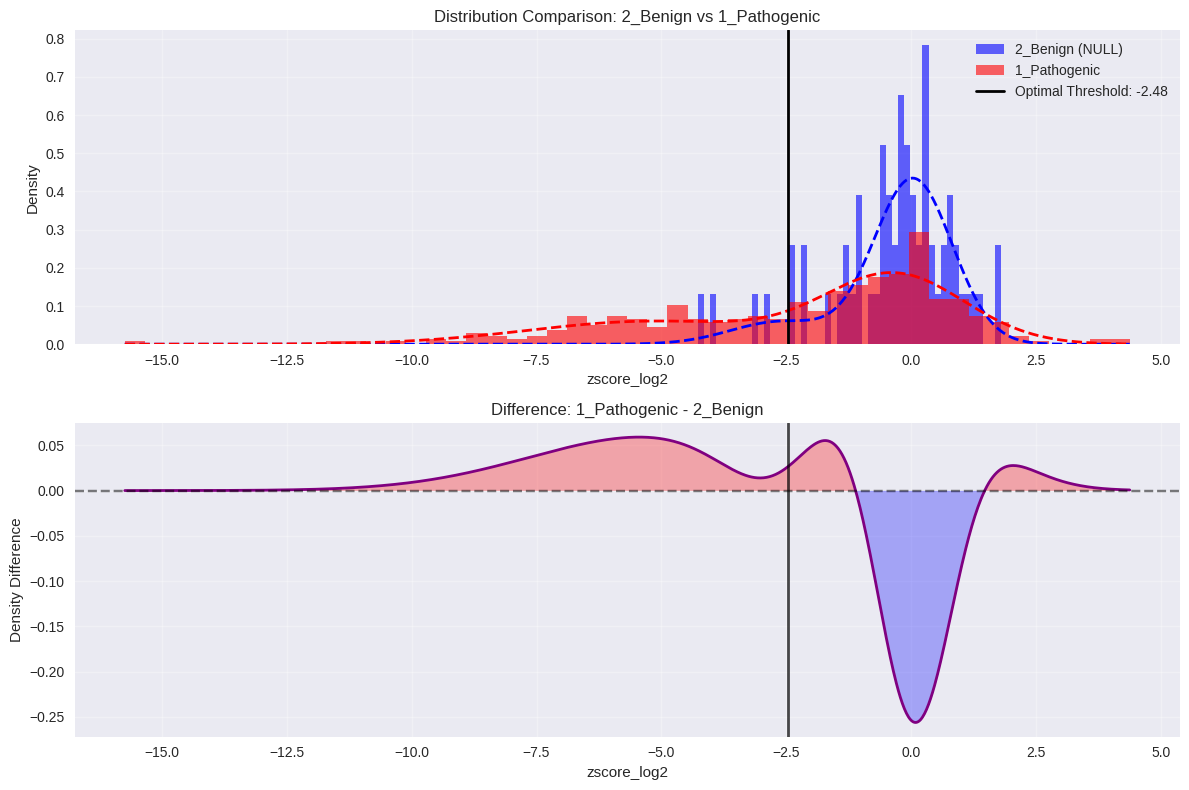

Threshold Analysis Results:
Optimal Threshold: -2.477
2_Benign Accuracy: 0.937
1_Pathogenic Accuracy: 0.369
Overall Accuracy: 0.653
\nAnalyzing 3_Conflicting vs 2_Benign:


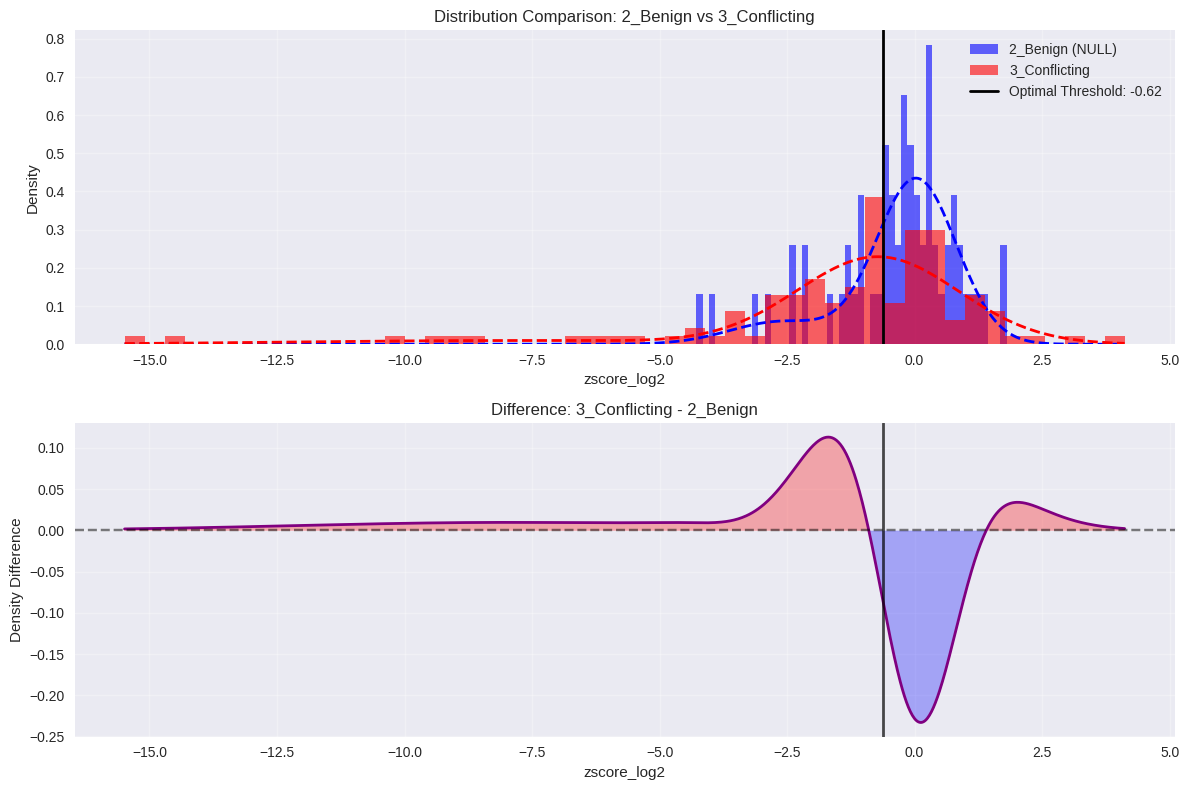

Threshold Analysis Results:
Optimal Threshold: -0.621
2_Benign Accuracy: 0.714
3_Conflicting Accuracy: 0.571
Overall Accuracy: 0.643
\nAnalyzing 4_VUS vs 2_Benign:


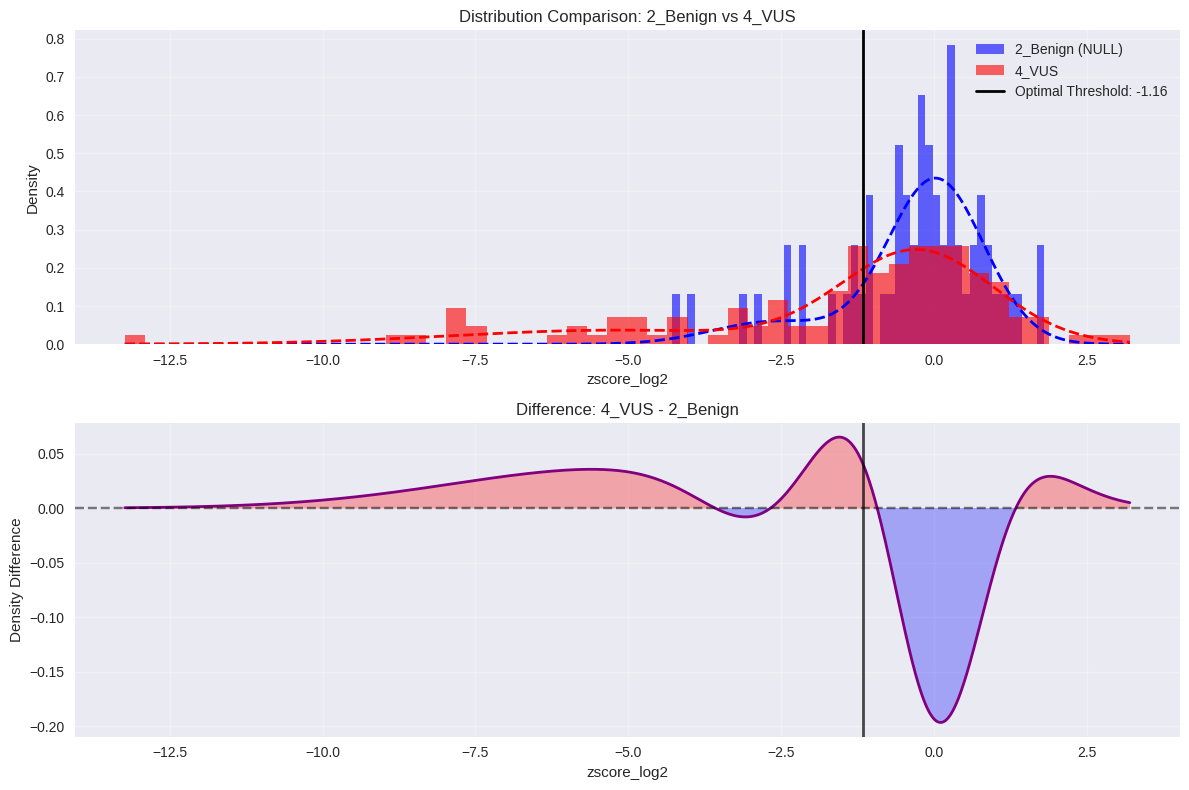

Threshold Analysis Results:
Optimal Threshold: -1.159
2_Benign Accuracy: 0.794
4_VUS Accuracy: 0.431
Overall Accuracy: 0.612


In [52]:
clinvar_data_dict = {
    '1_Pathogenic': scores.filter(pl.col('clinvar_clnsig_clean')=='1_Pathogenic')['zscore_log2'].to_numpy(),
    '2_Benign': scores.filter(pl.col('clinvar_clnsig_clean')=='2_Benign')['zscore_log2'].to_numpy(),
    '3_Conflicting': scores.filter(pl.col('clinvar_clnsig_clean')=='3_Conflicting')['zscore_log2'].to_numpy(),
    '4_VUS': scores.filter(pl.col('clinvar_clnsig_clean')=='4_VUS')['zscore_log2'].to_numpy(),
}

# Initialize analyzer
analyzer = DistributionAnalyzer(clinvar_data_dict)

# Fit GMM models for all categories
print("Fitting Gaussian Mixture Models...")
analyzer.fit_all_categories()

# Plot distributions with GMM fits
print("Plotting distributions with GMM overlays...")
analyzer.plot_distributions_with_gmm()

# Generate comprehensive report
analyzer.generate_summary_report()

# Compare specific categories with threshold analysis
print("=== THRESHOLD ANALYSIS ===")
categories_to_compare = ['1_Pathogenic', '3_Conflicting', '4_VUS']

for category in categories_to_compare:
    print(f"\\nAnalyzing {category} vs 2_Benign:")
    analyzer.plot_comparison_with_threshold('2_Benign', category)

In [53]:
thresh = analyzer.find_optimal_threshold()
thresh

{'threshold': -2.477404509022231,
 'null_accuracy': 0.9365079365079365,
 'target_accuracy': 0.3687315634218289,
 'overall_accuracy': 0.6526197499648827}

# of Benign variants: 63
# of Pathogenic variants: 339
# of VUS variants: 130
# of Conflicting variants: 119


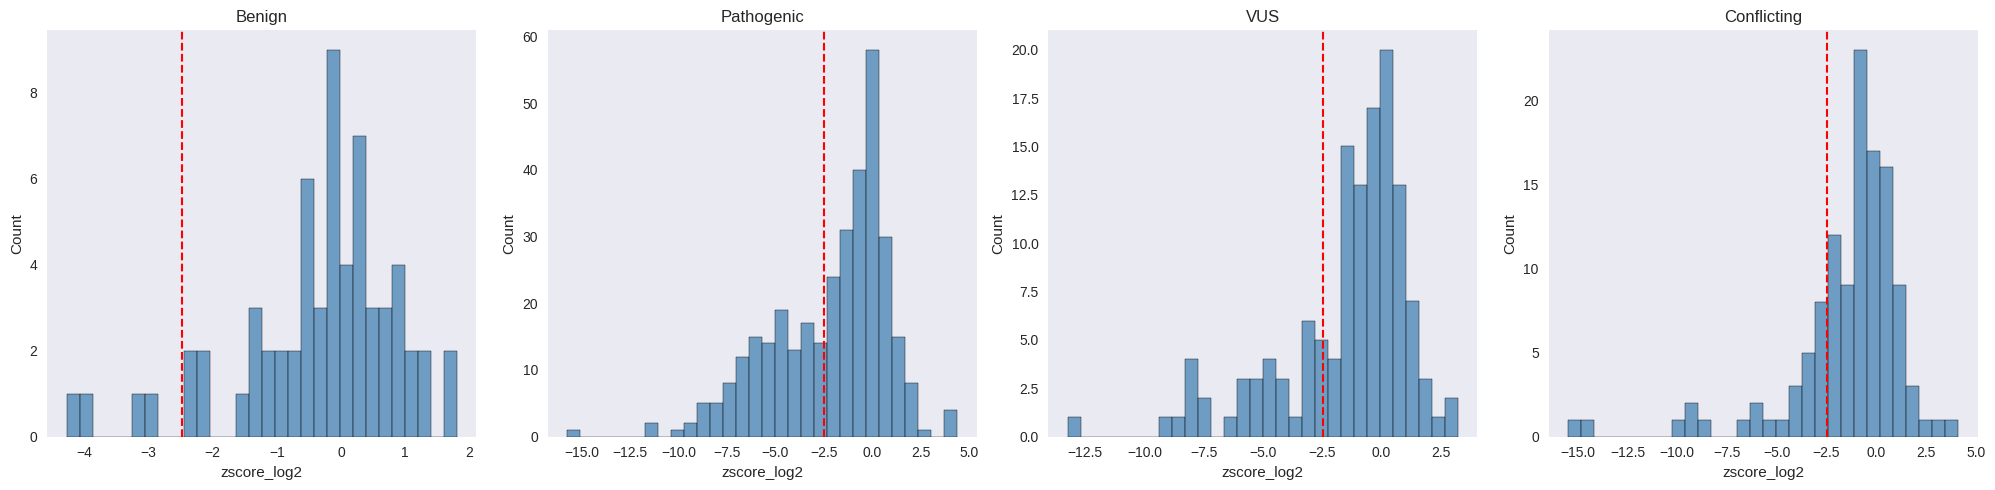

Optimal thresh found at -2.477
With this threshold, we classify 26.154% VUS,
AND 22.689% conflicting alleles as pathogenic.
This threshold classifies 6.349% of benign variants as pathogenic


In [54]:
plot_var = "zscore_log2"
optimal_threshold = analyzer.find_optimal_threshold()["threshold"]

benign_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign")
print("# of Benign variants:", benign_scores.shape[0])

path_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "1_Pathogenic")
print("# of Pathogenic variants:", path_scores.shape[0])

vus_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "4_VUS")
print("# of VUS variants:", vus_scores.shape[0])

conf_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "3_Conflicting")
print("# of Conflicting variants:", conf_scores.shape[0])

# Setup subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_data = [
    ("Benign", benign_scores, axs[0]),
    ("Pathogenic", path_scores, axs[1]),
    ("VUS", vus_scores, axs[2]),
    ("Conflicting", conf_scores, axs[3]),
]

# Plot each group
for title, data, ax in plot_data:
    sns.histplot(data=data, x=plot_var, bins=30, color="steelblue", kde=False, ax=ax)
    ax.axvline(optimal_threshold, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel(plot_var)
    ax.set_ylabel("Count")
    ax.grid(False)

plt.tight_layout()
plt.show()

benign_misclass = benign_scores.filter(pl.col(plot_var) < optimal_threshold).shape[0]
benign_total = benign_scores.shape[0]
print(f"Optimal thresh found at {optimal_threshold:.3f}")
print(f"With this threshold, we classify {vus_scores.filter(pl.col(plot_var) < optimal_threshold).shape[0]/vus_scores.shape[0]*100:.3f}% VUS,")
print(f"AND {conf_scores.filter(pl.col(plot_var) < optimal_threshold).shape[0]/conf_scores.shape[0]*100:.3f}% conflicting alleles as pathogenic.")
print(f"This threshold classifies {benign_misclass/benign_total*100:.3f}% of benign variants as pathogenic")
# This is ~13.4% of VUS/conflicting

In [55]:
scores = scores.with_columns(
    pl.when(pl.col(plot_var)<optimal_threshold)
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("dualipa_abund_change"),
    pl.lit(True).alias("dualipa_assayed"),
    pl.lit(optimal_threshold).alias("dualipa_threshold")
)

In [56]:
scores

symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,…,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool,bool,f64
"""KCNJ2""","""899G>A""","""Gly300Asp""","""KCNJ2_Gly300Asp""",693.679993,5069.049805,0.133067,0.841771,0.15808,-1.835174,-1.0,-5.882805,"""ENSG00000123700""","""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""","""1""","""VUSMutGDDh010""","""G06""","""VUSN2Hmut_GDN2h_03""","""H09""","""VUSMutpDEST2_16""","""G04""","""VUSmut_GDEh03""","""H09""",1,2,1,2,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.477405
"""HBD""","""174C>A""","""Asn58Lys""","""HBD_Asn58Lys""",33.84,2474.280029,0.012192,0.077713,0.156882,-1.837623,-1.0,-5.907103,"""ENSG00000223609""","""CCSBVarC006560""","""ALE00006559""","""NC_000011.10:5234132:G:T""","""CEGS2""","""CegsMutGDEh1047""","""D02""","""GDEhDisVCh_40036""","""D03""","""2""","""CegsMutGDDh1047""","""D02""","""VUSN2Hmut_GDN2h_10""","""C04""","""VUSMutpDEST2_11""","""H05""","""VUSmut_GDEh10""","""C04""",1,1,1,1,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.477405
"""SMAD3""","""376C>T""","""His126Tyr""","""SMAD3_His126Tyr""",993.600037,3757.339966,0.267095,1.033889,0.25834,-1.630252,-1.0,-4.313822,"""ENSG00000166949""","""CCSBVarC007714""","""ALE00007700""","""NC_000015.10:67165064:C:T""","""Edgotyping3""","""VUSMutGDEh004""","""D11""","""GDEhDisVCh_40014""","""D06""","""2""","""VUSMutGDDh004""","""D11""","""NULL""","""NULL""","""VUSMutpDEST2_09""","""B02""","""NULL""","""NULL""",1,1,1,1,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.477405
"""HBD""","""110C>A""","""Pro37His""","""HBD_Pro37His""",31.9

In [57]:
## only keep the non-nulls
scores.write_csv(f"{dualipa_outputs}/annotated_perturbation_scores.csv")
scores.write_csv(f"{integrative_inputs}/abun_scores.csv")